<a href="https://colab.research.google.com/github/AllergictoCrustaceans/ML/blob/main/Kmeans_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Detect Heart Disease**

Prompt: Given biometrics of patient, detect the presence of heart disease. 

ML Problem Type: Clustering with Manual Similarity Measure

What is data from: https://archive.ics.uci.edu/ml/datasets/heart+disease and it is labeled.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


### 1.) Load Dataset

Of the 13 features in the dataset, five features are numerical, and the rest are categorical. I make a note of this at the cell below:
- num = numerical 
- ohe = categorical (should one hot encode (ohe) when preprocessing)

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

"""
FEATURES: 
1.) (num.) age: the patient's age
2.) (ohe.) sex: the patient's sex (1 = male, 0 = female)
3.) (ohe.) cp: Chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
4.) (num.) trestbps: resting blood pressure (in mm Hg)
5.) (num.) chol: serum cholestoral in mg/dl
6.) (ohe.) fbs: fasthing blood sugar > 120 mg/dl (1 = True, 0 = False)
7.) (ohe.) restecg: resting electrocardiographics results (0 = normal, 1 = have ST-T wave abnormality via T wave inversions and/or ST elevation OR depression of > 0.05 mV)
8.) (num.) thalach: max heart rate achieved
9.) (ohe.) exang: exercised induced angina (1 = True, 0 = False)
10.) (num.) oldpeak: ST depression induced by exercise relative to rest
11.) (ohe.) slope: slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
12.) (ohe.) ca: number of major vessels (0-3) colored by floursopy
13.) (ohe.) thal: 3 = normal, 6 = fixed defect, 7 = reversable defect

LABEL:
14.) (ohe.) num: diagnosis of heart disease (angiographic disease status) (0 = <50% diameter narrowing, 1 = >50% diameter narrowing) 
but you see numbers (0-4) on the dataset instead. where anything that is NOT 0 has chance of heart disease being present. Otherwise, it is 0.

"""

ds_raw = pd.read_csv(url, header=0, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

### 2.) Inspect



In [3]:
# data info
ds_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   cp        302 non-null    float64
 3   trestbps  302 non-null    float64
 4   chol      302 non-null    float64
 5   fbs       302 non-null    float64
 6   restecg   302 non-null    float64
 7   thalach   302 non-null    float64
 8   exang     302 non-null    float64
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    float64
 11  ca        298 non-null    float64
 12  thal      300 non-null    float64
 13  num       302 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.2 KB


Some things I immediately notice:

- All features' 'Dtype' are 'float64'. So, seems like categorical features have been encoded in some fashion already. 
-  Label's 'Dtype' is 'int64'. In order to keep consistency, I will make this a float.
- All features except 'ca', and 'thal' have 302 data entries. 

In [4]:
# check for misspelling
# n/a

# check for nulls
ds_raw.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

Checking for nulls here just further confirms that the last two features are missing values. I will make sure to fill in the missing values with the average value corresponding to their respective column.

In [5]:
# describe data 
ds_raw.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,298.000000,300.000000,302.000000
mean,54.410596,0.678808,3.165563,131.645695,246.738411,0.145695,0.986755,149.605960,0.327815,1.035430,1.596026,0.674497,4.730000,0.940397
std,9.040163,0.467709,0.953612,17.612202,51.856829,0.353386,0.994916,22.912959,0.470196,1.160723,0.611939,0.938202,1.941563,1.229384
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,55.500000,1.000000,3.000000,130.000000,241.500000,0.000000,0.500000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [6]:
# for funsies, let's check out what the dataframe looks like.
ds_raw.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


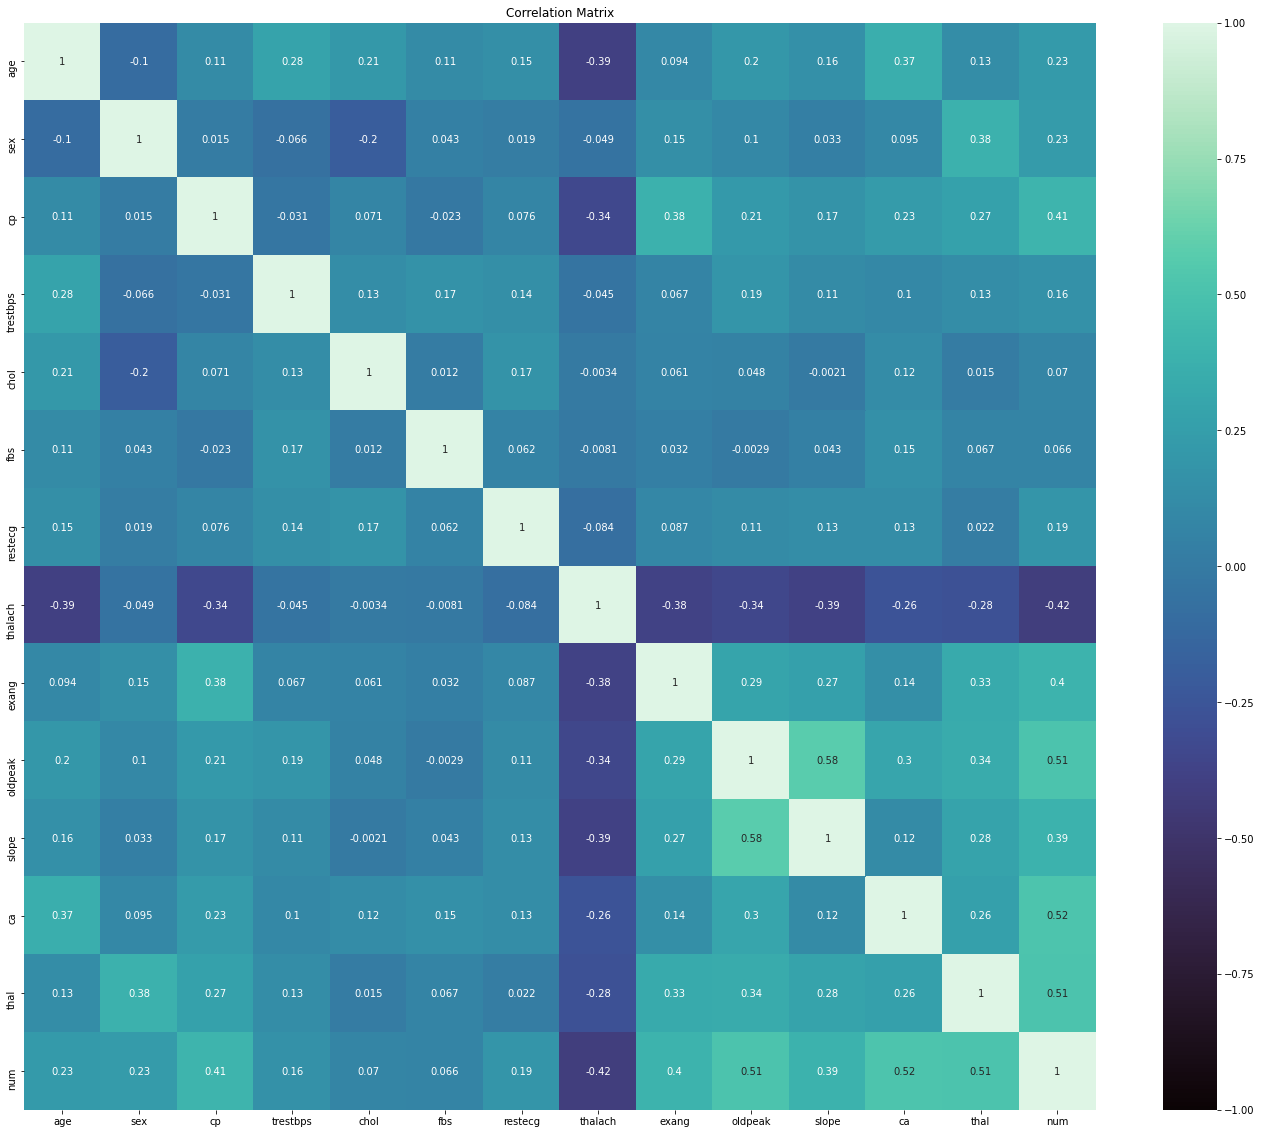

In [7]:
# check feature redundancy via correlation matrix of features
corr = ds_raw.corr()
plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Matrix')
plt.show()

Correlation matrix doesn't appear to show high correlation between any two variables. However, there are probably better ways to check for feature redundancy via Chi-square test, ANOVA. 

Note to self: Try playing with this later. 

### 3.) Clean

Since 'ca' and 'thal' are categorical features, I will fill the nulls with their most frequent value in their respective column.

In [8]:
#fill na of 'ca', and 'thal'
ds_raw['ca'].fillna(ds_raw['ca'].mode()[0], inplace=True)
ds_raw['thal'].fillna(ds_raw['thal'].mode()[0], inplace=True)

In [9]:
# check nulls again
ds_raw.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

### 4.) Preprocess

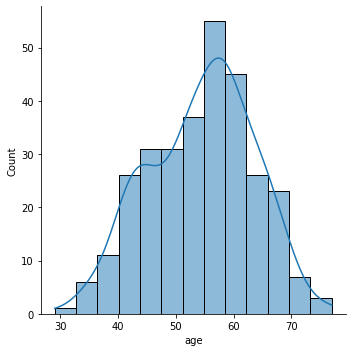

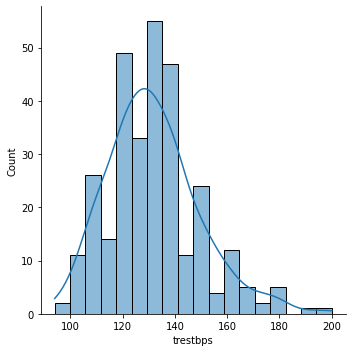

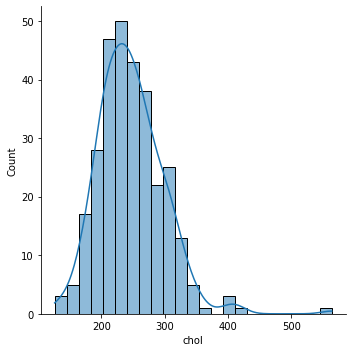

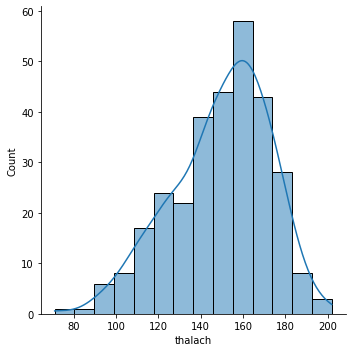

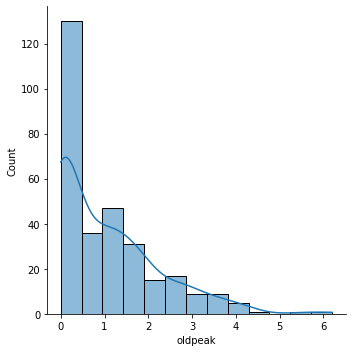

In [14]:
ds = ds_raw.copy()
original_cols = ds_raw.columns.values
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# check distribution of numerical features
for col in num_cols:
    sns.displot(ds[col], kde=True)


In [15]:
# Y-LABEL is categorical
ds['num2'] = ds['num']

# NUMERICALS:
# age is gaussian, normalize z-score
ds['age'] = (ds['age'] - ds['age'].mean()) / ds['age'].std()

# trestbps needs log transformation.
ds['trestbps'] = np.log(ds['trestbps'])

# chol needs feature clipping because of the outlier.
ds['chol'] = np.log(ds['chol'])

# thalach needs power square root transformation.
ds['thalach'] = np.sqrt(max(ds['thalach']) + 1 - ds['thalach'])

# oldpeak needs log transformation.
ds['oldpeak'] = np.log(ds['oldpeak'] + 1)

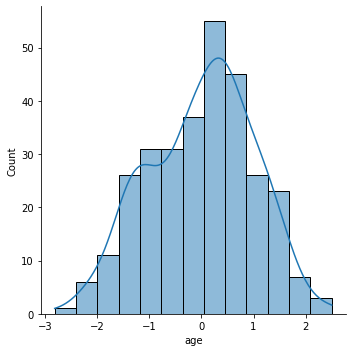

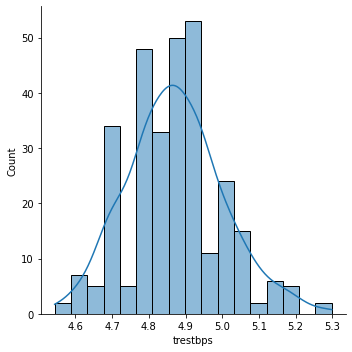

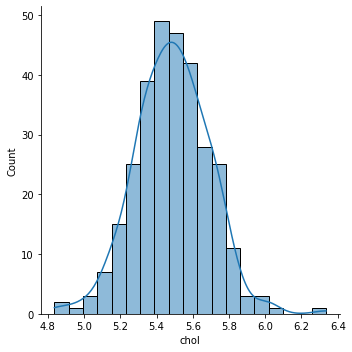

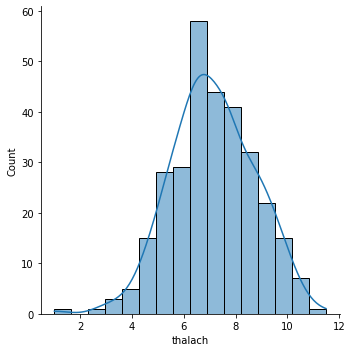

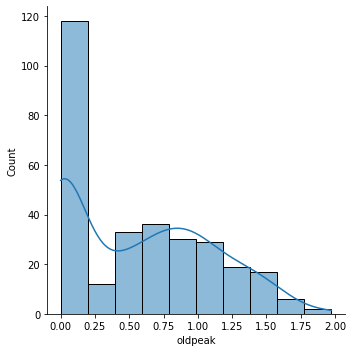

In [16]:
# recheck distribution of numerical columns
for col in num_cols:
    sns.displot(ds[col], kde=True)

All plots look to have a more normal distribution now, except 'oldpeak'. 

I should look up how else to fix this transformation. If not log transformation, then what? 

In [17]:
# CATEGORICALS:
# convert data's original categorical variables back to string
ds['sex'] = ds['sex'].map({0: 'female', 1: 'male'})
ds['cp'] = ds['cp'].map({1: 'typical_angina', 2: 'atypical_angina', 3: 'non_anginal_pain', 4: 'asymptomatic'})
ds['fbs'] = ds['fbs'].map({0: 'False', 1: 'True'})
ds['restecg'] = ds['restecg'].map({0: 'normal', 1: 'ST-T_wave_abnorm.', 2: 'left_ventr_hypertrophy'})
ds['exang'] = ds['exang'].map({0: 'False', 1: 'True'})
ds['slope'] = ds['slope'].map({1: 'upsloping', 2: 'flat', 3: 'downsloping'})
ds['thal'] = ds['thal'].map({3: 'normal', 6: 'fixed_defect', 7: 'revers._defect'})

# convert categorical features' string values to ohe values
ds['sex2'] = ds['sex']
ds['cp2'] = ds['cp']
ds['fbs2'] = ds['fbs']
ds['restecg2'] = ds['restecg']
ds['exang2'] = ds['exang']
ds['slope2'] = ds['slope']
ds['thal2'] = ds['thal']

ds = pd.get_dummies(ds, columns=['sex2'], prefix=['sex']) 
ds = pd.get_dummies(ds, columns=['cp2'], prefix=['cp'])
ds = pd.get_dummies(ds, columns=['fbs2'], prefix=['fbs'])
ds = pd.get_dummies(ds, columns=['restecg2'], prefix=['restecg'])
ds = pd.get_dummies(ds, columns=['exang2'], prefix=['exang'])
ds = pd.get_dummies(ds, columns=['slope2'], prefix=['slope'])
ds = pd.get_dummies(ds, columns=['thal2'], prefix=['thal'])

ds.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,num2,sex_female,sex_male,cp_asymptomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,fbs_False,fbs_True,restecg_ST-T_wave_abnorm.,restecg_left_ventr_hypertrophy,restecg_normal,exang_False,exang_True,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_revers._defect
0,1.392608,male,asymptomatic,5.075174,5.655992,False,left_ventr_hypertrophy,9.746794,True,0.916291,flat,3.0,normal,2,2,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0
1,1.392608,male,asymptomatic,4.787492,5.433722,False,left_ventr_hypertrophy,8.602325,True,1.280934,flat,2.0,revers._defect,1,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
2,-1.925916,male,non_anginal_pain,4.867534,5.521461,False,normal,4.000000,False,1.504077,downsloping,0.0,normal,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,1,0
3,-1.483446,female,atypical_angina,4.867534,5.318120,False,left_ventr_hypertrophy,5.567764,False,0.875469,upsloping,0.0,normal,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0
4,0.175816,male,atypical_angina,4.787492,5.463832,False,normal,5.000000,False,0.587787,upsloping,0.0,normal,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0


### 5.) Split

In [18]:
# original cleaned BUT un-preprocessed data
ds_original = ds.loc[:, original_cols].copy(deep=True)

# preprocessed data 
ds.drop(columns=original_cols, inplace=True)

# make sure all values are floats
ds = ds / 1.0

# check ds one last time
ds.tail()

,num2,sex_female,sex_male,cp_asymptomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,fbs_False,fbs_True,restecg_ST-T_wave_abnorm.,restecg_left_ventr_hypertrophy,restecg_normal,exang_False,exang_True,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_revers._defect
297,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
298,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
299,3.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
300,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
301,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### 6.) Elbow Test for Ideal K Cluster Number

In [19]:
from sklearn.cluster import KMeans

features = ds.loc[:, ds.columns != 'num2'].values
wcss= []

for i in range(1, 10):
    km = KMeans(n_clusters = i, 
                init = 'k-means++',
                max_iter=200,
                n_init=10,
                random_state=42)
    km.fit(features)
    wcss.append(km.inertia_)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


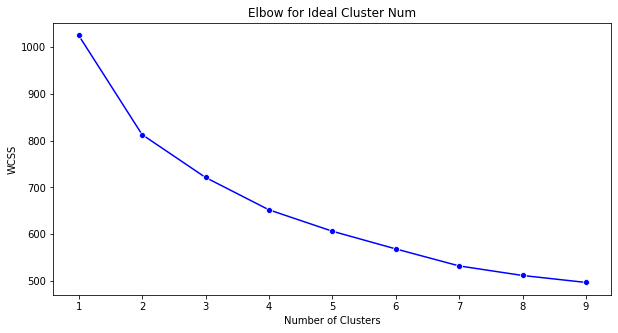

In [20]:
plt.figure(figsize=(10, 5))
sns.lineplot(range(1, 10), wcss, marker='o', color='blue')
plt.title('Elbow for Ideal Cluster Num')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

### 7.) K-Means Cluster

In [21]:
clustering_km = KMeans(n_clusters=10, init='kmeans++', n_jobs=-1)
y_km = km.fit_predict(features)

### 8.) Visualize Mutlivariate Cluster

I need to look more into this. 

Due to the amount of features, it may be ideal to perform PCA to reduce the number of dimensions. In order to do that, I need to indicate my first and second principal components. But how do I determine which features are most important? 